# Projet 9 : Produisez une étude de marché avec R ou Python

#### *Les librairies utiles pour le projet*

In [1]:
#Import des librairies Python
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import decomposition
import importlib.metadata
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

Matplotlib created a temporary cache directory at /tmp/matplotlib-y6uaseld because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
!python --version

# Version des bibliothèques utilisées (standard)
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

# Version des bibliothèques utilisées (import non complet)
# Cela suppose que tu comptes utiliser matplotlib
print("matplotlib - ", importlib.metadata.version('matplotlib'))

Python 3.10.13
pandas - 2.1.4
seaborn - 0.12.2
numpy - 1.25.2
missingno - 0.5.2
numpy - 1.25.2
matplotlib -  3.8.2


In [5]:
pd.set_option('display.max_rows', None)

## BDD_Finale

In [6]:
# Importer le fichier population 
BDD_P9_final = pd.read_csv('RESULTATS/BDD_P9_final_07mars.csv')
BDD_P9_final = BDD_P9_final[BDD_P9_final['Pays'] != 'Chine']
BDD_P9_final = BDD_P9_final[BDD_P9_final['Pays'] != 'France']
BDD_P9_final.drop(columns=["Dispo_prot_tot","Dispo_prot_animal",'Croi_démo(%)2012-2019', 'Variation_de_stock',"Import_Dispo(%)","Prod_Dispo(%)","Exportations"], inplace=True)
display(BDD_P9_final.head())

,Pays,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production
0,Pays-Bas,62.72,56784.0,17363.26,0.85,3468.0,161000.0,602000.0,1048000.0
1,Afghanistan,17.76,2079.9,37769.50,-2.66,2228.0,69000.0,44000.0,28000.0
2,Afrique du Sud,45.17,13852.2,58087.06,-0.27,2827.0,2178000.0,488000.0,1816000.0
3,Albanie,53.10,13653.2,2873.88,0.11,3375.0,35000.0,22000.0,13000.0
4,Algérie,27.00,11627.3,42705.37,-1.04,3478.0,280000.0,0.0,285000.0


In [7]:
BDD_P9_final.isna().mean()

Pays                        0.000000
Pourcentage_prot_animal     0.000000
PIB                         0.048913
Population                  0.000000
Stapilite_politique         0.021739
Dispo_kcal_per_J            0.000000
Disponibilité_intérieure    0.000000
Importations                0.000000
Production                  0.000000
dtype: float64

# PIB == NA
- Chine, Taiwan Province de 
- Cuba 
- Nouvelle-Calédonie
- Polynésie française
- République arabe syrienne
- République populaire démocratique de Corée
- Soudan du Sud
- Venezuela (République bolivarienne du)
- Yémen

# Stapilite_politique == NA
- Chine, continentale
- Chine, Taiwan Province de
- Nouvelle-Calédonie

In [9]:
# BDD_P9_final = BDD_P9_final.fillna(df.mean())
BDD_P9_final.fillna(0, inplace=True)
BDD_P9_final.isna().mean()

Pays                        0.0
Pourcentage_prot_animal     0.0
PIB                         0.0
Population                  0.0
Stapilite_politique         0.0
Dispo_kcal_per_J            0.0
Disponibilité_intérieure    0.0
Importations                0.0
Production                  0.0
dtype: float64

## Variable centrée réduite
Afin de rendre les variables comparables entre elles pour notre clustering, nous allons les centrer/reduire.

In [10]:
BDD_P9_final.set_index('Pays',inplace=True)

In [11]:
from sklearn import preprocessing
#Valeur de nos variable dans X
X = BDD_P9_final.values
#Centrage / réduction des données pour que nos données puissent prendre la même importance
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

## ANALYSE EN COMPOSANTES PRINCIPALES (ACP)
cette méthode vise à réduire le nombre de variables appliquées à des individus, pour simplifier les observations tout en conservant un maximum d’informations.

### Eboulis des valeurs propres

In [12]:
# Calcul des composantes principales
pca = decomposition.PCA()
pca.fit(X_scaled)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.38438014 0.31432378 0.10488569 0.06699262 0.05224426 0.03842597
 0.03798069 0.00076686]
0.9999999999999999


In [13]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

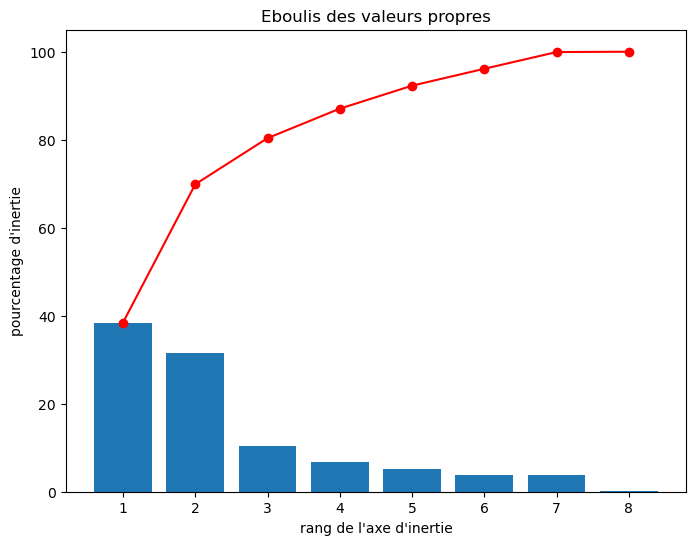

In [14]:
#Afficher la figure
figure1 = plt.figure(figsize=(8,6))
display_scree_plot(pca)
plt.show()

Observation eboulis :
Nous garderons 4 axes :

- Axe 1 : 38,7% de l'inertie totale
- Axe 2 : 31,4% de l'inertie totale
- Axe 3 : 10,4% de l'inertie totale
- Axe 4 : 06,7% de l'inertie totale


**Pour un total de 87,2% de l'information totale**

### Correlation de nos variable sur les composantes principales

In [15]:
# création de la matrice de corrélation
t=pca.components_[:]
BDD_P9_corr_comp = pd.DataFrame(t,index = ['F1', 'F2', 'F3','F4','F5','F6','F7','F8'],columns=BDD_P9_final.columns)
BDD_P9_corr_comp.head(4)

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production
F1,0.381404,0.396872,0.242623,0.285168,0.422046,0.388696,0.286044,0.381848
F2,-0.341428,-0.314994,0.455920,-0.376493,-0.245554,0.435577,0.090766,0.419921
F3,-0.140574,0.119510,-0.113372,-0.269972,-0.029743,-0.137155,0.902659,-0.213845
F4,0.092793,-0.257707,0.264127,0.711025,-0.526865,-0.037038,0.249896,-0.090831


Premier axe F1 :
Il représente Dispo_kcal_per_J (0.42)

Deuxieme axe F2 :
Il représente Population (0.46), Disponibilité_intérieure (0.44) ainsi que Production (0.42)

Troisième axe F3 :
Il représente Importations (0.90)

Quatrième axe F4 :
Il représente Stapilite_politique (0.71) et Dispo_kcal_per_J (0.52)

### Qualité de représentation des individus

Pour calculer la qualité de représentation des individus sur les axes, nous devons d’abord calculer les carrés des distances à l’origine des individus, qui correspondent également à leur contribution dans l’inertie totale

In [16]:
di = np.sum(X_scaled**2,axis=1) #pourcentage d'inertie

BDD_P9_ctr_ind = pd.DataFrame({'Pays':BDD_P9_final.index,'d_i':di})
BDD_P9_ctr_ind

,Pays,d_i
0,Pays-Bas,14.499248
1,Afghanistan,12.689514
2,Afrique du Sud,5.235486
3,Albanie,1.912651
4,Algérie,3.839834
5,Allemagne,22.751565
6,Angola,3.439604
7,Antigua-et-Barbuda,4.512369
8,Arabie saoudite,11.103566
9,Argentine,2.790447


In [17]:
BDD_P9_ctr_ind.sort_values(by= "d_i", ascending = False)

,Pays,d_i
37,"Chine, continentale",236.994464
57,États-Unis d'Amérique,154.665675
76,Inde,87.322583
26,Brésil,47.220710
109,Mexique,36.788013
85,Japon,35.497509
36,Chine - RAS de Macao,27.754501
98,Luxembourg,25.535154
5,Allemagne,22.751565
35,Chine - RAS de Hong-Kong,21.169553


In [18]:
coord = pca.fit_transform(X_scaled)
#qualité de représentation des individus par dimensions- COS2
cos2 = coord**2
p=4 # nombre de variables
for j in range(p):
    cos2[:,j] = cos2[:,j]/di
    BDD_P9_4V = pd.DataFrame({'id':BDD_P9_final.index,
                              'COS2_1':cos2[:,0],
                              'COS2_2':cos2[:,1],
                              'COS2_3':cos2[:,2],
                              'COS2_4':cos2[:,3]})
BDD_P9_4V

,id,COS2_1,COS2_2,COS2_3,COS2_4
0,Pays-Bas,0.487418,0.160094,0.331099,0.010774
1,Afghanistan,0.528357,0.284778,0.047492,0.093964
2,Afrique du Sud,0.145546,0.136797,0.555913,0.060559
3,Albanie,0.031956,0.382725,0.086703,0.061313
4,Algérie,0.076992,0.028152,0.000464,0.528685
5,Allemagne,0.516749,0.028290,0.439681,0.007207
6,Angola,0.312042,0.163936,0.344789,0.138895
7,Antigua-et-Barbuda,0.001028,0.269655,0.109117,0.358560
8,Arabie saoudite,0.199238,0.001911,0.773759,0.009819
9,Argentine,0.472903,0.008032,0.220334,0.085724


Nous avons la qualité de representation des individus (ici des pays) sur les 5 dimensions de l'ACP

### Qualité de représentation des variables
Nous avons une idée des individus que nous allons pouvoir étudier.

La prochaine étape est de caractériser nos composantes principales. Pour rappel, chaque composante est composé d'une combinaison linéaire des variables corrélés de notre jeu de données d'entré. Chaque composante est décorrélé

In [19]:
#Nous avons besoin des vecteurs propres pour l’analyse des variables. Ils sont fournis par le champ .components_de l'objet ACP
print(pca.components_)

[[ 3.81403886e-01  3.96871543e-01  2.42622965e-01  2.85168466e-01
   4.22046214e-01  3.88696257e-01  2.86044162e-01  3.81848199e-01]
 [-3.41427815e-01 -3.14994075e-01  4.55919525e-01 -3.76492997e-01
  -2.45553619e-01  4.35577291e-01  9.07662489e-02  4.19920852e-01]
 [-1.40573502e-01  1.19510132e-01 -1.13372369e-01 -2.69972496e-01
  -2.97432162e-02 -1.37154696e-01  9.02658513e-01 -2.13844604e-01]
 [ 9.27927490e-02 -2.57707345e-01  2.64127478e-01  7.11025200e-01
  -5.26864606e-01 -3.70383185e-02  2.49895800e-01 -9.08306694e-02]
 [-4.31728628e-01  3.83078751e-01  6.67025415e-01  7.82835110e-02
   1.93194045e-01 -2.51682830e-01 -1.18008540e-01 -3.18144067e-01]
 [ 6.44064130e-01 -3.90201581e-01  4.42932948e-01 -3.29228805e-01
   1.51210440e-01 -1.97837483e-01  2.32814601e-02 -2.56508532e-01]
 [ 3.29193563e-01  6.02889886e-01  7.76597979e-02 -2.89762446e-01
  -6.50323688e-01  3.21242410e-03 -1.22011659e-01  1.85472518e-02]
 [-3.17876546e-03 -9.65122592e-03  5.92563848e-02  2.79230629e-03
   

In [20]:
#obtenir les variances ou valeurs propres
n = BDD_P9_final.shape[0]
VP = (n-1)/n*pca.explained_variance_
VP

array([3.07504113, 2.5145902 , 0.83908552, 0.53594094, 0.41795411,
       0.30740772, 0.30384551, 0.00613486])

In [21]:
#variance expliquée
VP = pca.explained_variance_
#racine carrée des valeurs propres
R2VP = np.sqrt(VP)

In [22]:
#corrélation des variables avec les axes
k = 8

corvar = numpy.zeros((k, p))

for k in range(p):
    corvar[:,k] = pca.components_[k,:] * R2VP[k]
    
    

    #afficher la matrice des corrélations variables x facteurs
print(corvar.T)

[[ 0.67064694  0.69784471  0.42661953  0.50143002  0.74211095  0.68346958
   0.50296981  0.6714282 ]
 [-0.54289504 -0.50086347  0.72494518 -0.59865123 -0.3904481   0.69259955
   0.14432493  0.66770467]
 [-0.12911894  0.10977191 -0.10413428 -0.24797392 -0.0273196  -0.12597871
   0.82910582 -0.19641958]
 [ 0.06811706 -0.18917713  0.19389     0.52194751 -0.38675938 -0.02718899
   0.18344285 -0.06667674]]


In [23]:
Matrice_de_correlation = pd.DataFrame({'variables':BDD_P9_final.columns,
                                       'COR_1':corvar[:,0],
                                       'COR_2':corvar[:,1],
                                       'COR_3':corvar[:,2],
                                       'COR_4':corvar[:,3]})
Matrice_de_correlation

,variables,COR_1,COR_2,COR_3,COR_4
0,Pourcentage_prot_animal,0.670647,-0.542895,-0.129119,0.068117
1,PIB,0.697845,-0.500863,0.109772,-0.189177
2,Population,0.426620,0.724945,-0.104134,0.193890
3,Stapilite_politique,0.501430,-0.598651,-0.247974,0.521948
4,Dispo_kcal_per_J,0.742111,-0.390448,-0.027320,-0.386759
5,Disponibilité_intérieure,0.683470,0.692600,-0.125979,-0.027189
6,Importations,0.502970,0.144325,0.829106,0.183443
7,Production,0.671428,0.667705,-0.196420,-0.066677


On peut finalement afficher la qualité de représentation de nos variables sur les 4 premiers axes

In [24]:
cos2var = corvar**2
DF_COS2 = pd.DataFrame({'variables':BDD_P9_final.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1],'COS2_3':cos2var[:,2],'COS2_4':cos2var[:,3]})
DF_COS2

,variables,COS2_1,COS2_2,COS2_3,COS2_4
0,Pourcentage_prot_animal,0.449767,0.294735,0.016672,0.004640
1,PIB,0.486987,0.250864,0.012050,0.035788
2,Population,0.182004,0.525546,0.010844,0.037593
3,Stapilite_politique,0.251432,0.358383,0.061491,0.272429
4,Dispo_kcal_per_J,0.550729,0.152450,0.000746,0.149583
5,Disponibilité_intérieure,0.467131,0.479694,0.015871,0.000739
6,Importations,0.252979,0.020830,0.687416,0.033651
7,Production,0.450816,0.445830,0.038581,0.004446


In [25]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='12', ha='left', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

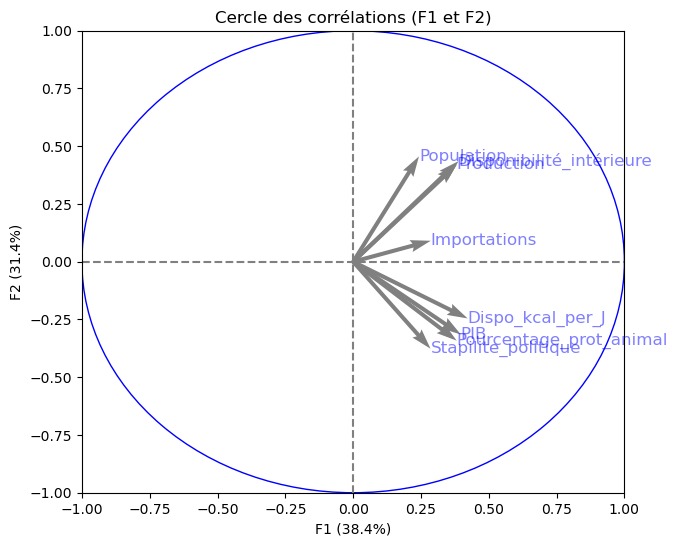

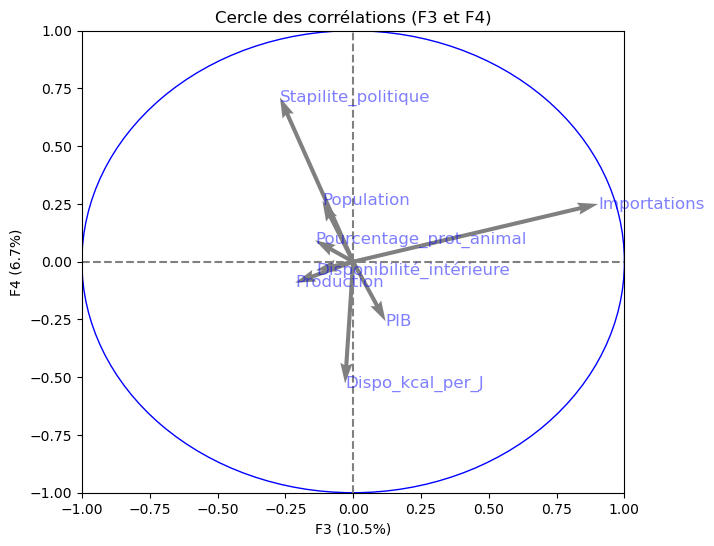

In [26]:
# choix du nombre de composantes à calculer
n_comp = 4
# selection des colonnes à prendre en compte dans l'ACP
features = BDD_P9_final.columns
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features) )
plt.show()

## Matrice des corellations linéaires de pearson

In [27]:
corr_BDD_P9_final = BDD_P9_final.corr(method='pearson')

corr_BDD_P9_final.style.background_gradient(cmap='coolwarm')

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production
Pourcentage_prot_animal,1.000000,0.622913,-0.105263,0.616605,0.613146,0.102826,0.177209,0.116490
PIB,0.622913,1.000000,-0.044989,0.519900,0.673012,0.104779,0.289155,0.107684
Population,-0.105263,-0.044989,1.000000,-0.122381,0.020715,0.699875,0.234388,0.650854
Stapilite_politique,0.616605,0.519900,-0.122381,1.000000,0.456807,-0.043075,0.060177,-0.034946
Dispo_kcal_per_J,0.613146,0.673012,0.020715,0.456807,1.000000,0.219227,0.237758,0.225987
Disponibilité_intérieure,0.102826,0.104779,0.699875,-0.043075,0.219227,1.000000,0.343089,0.988807
Importations,0.177209,0.289155,0.234388,0.060177,0.237758,0.343089,1.000000,0.270991
Production,0.116490,0.107684,0.650854,-0.034946,0.225987,0.988807,0.270991,1.000000


## CLASSIFICATION ASCENDANTE HIÉRARCHIQUE (CAH)

### Dendrogramme

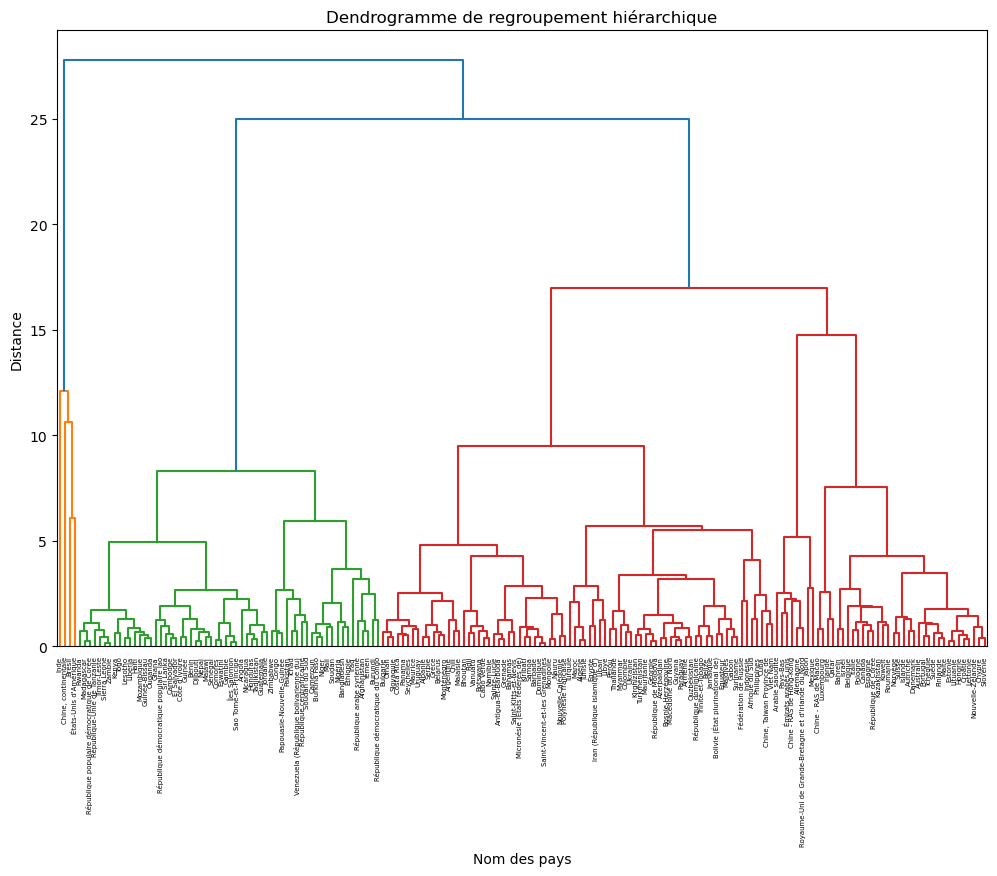

In [30]:
#Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward
Z = linkage(X_scaled, method="ward", metric='euclidean')

#generer le dendrogramme 
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

_ = dendrogram(Z,labels= BDD_P9_final.index, ax=ax)

plt.title("Dendrogramme de regroupement hiérarchique")
plt.xlabel("Nom des pays")
plt.ylabel("Distance")
plt.show()

J'ai decidé de garder 4 clusters

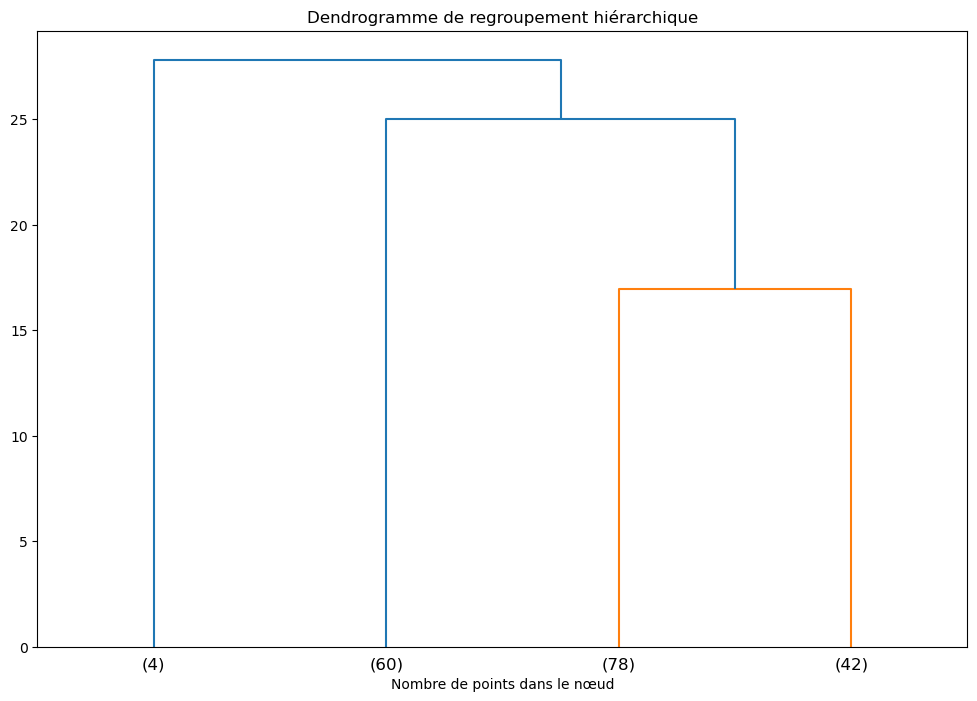

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

_ = dendrogram(Z,p=4, truncate_mode="lastp", ax=ax)

plt.title("Dendrogramme de regroupement hiérarchique")
plt.xlabel("Nombre de points dans le nœud")
plt.show()

In [32]:
groupecah=fcluster(Z, 4, criterion='maxclust')
#Affichage des pays selon leurs groupes
BDD_P9_2 = pd.DataFrame({'clusters_cah': groupecah, 'Pays': BDD_P9_final.index})
BDD_P9_2.head()

,clusters_cah,Pays
0,4,Pays-Bas
1,2,Afghanistan
2,3,Afrique du Sud
3,3,Albanie
4,3,Algérie


In [33]:
#Jointure des cluester CAH sur notre dataframe de base
BDD_P9_3 = pd.merge(BDD_P9_final, BDD_P9_2, on='Pays')
BDD_P9_3.set_index('Pays', inplace=True)
BDD_P9_3.head()

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,clusters_cah
Pays,,,,,,,,,
Pays-Bas,62.72,56784.0,17363.26,0.85,3468.0,161000.0,602000.0,1048000.0,4
Afghanistan,17.76,2079.9,37769.50,-2.66,2228.0,69000.0,44000.0,28000.0,2
Afrique du Sud,45.17,13852.2,58087.06,-0.27,2827.0,2178000.0,488000.0,1816000.0,3
Albanie,53.10,13653.2,2873.88,0.11,3375.0,35000.0,22000.0,13000.0,3
Algérie,27.00,11627.3,42705.37,-1.04,3478.0,280000.0,0.0,285000.0,3


## Présentation des clusters

In [34]:
cluster_1= BDD_P9_3[BDD_P9_3['clusters_cah']==1]
cluster_1

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,clusters_cah
Pays,,,,,,,,,
Brésil,58.70,14685.1,211782.88,-0.71,3281.0,9952000.0,5000.0,14094000.0,1
"Chine, continentale",38.65,15977.8,1421864.03,0.00,3304.0,20738000.0,795000.0,20761000.0,1
États-Unis d'Amérique,64.75,62478.3,334319.67,0.13,3876.0,19225000.0,123000.0,22878000.0,1
Inde,23.29,6608.6,1383112.05,-0.77,2537.0,4382000.0,0.0,4387000.0,1


In [35]:
cluster_2= BDD_P9_3[BDD_P9_3['clusters_cah']==2]
cluster_2

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,clusters_cah
Pays,,,,,,,,,
Afghanistan,17.76,2079.9,37769.50,-2.66,2228.0,69000.0,44000.0,28000.0,2
Angola,27.20,6602.4,32353.59,-0.36,2427.0,314000.0,265000.0,49000.0,2
Bangladesh,20.26,5467.2,165516.22,-0.93,2513.0,260000.0,0.0,260000.0,2
Bénin,17.89,3156.4,12290.44,-0.41,2687.0,121000.0,117000.0,15000.0,2
Burkina Faso,18.41,2110.1,20951.64,-1.30,2629.0,204000.0,0.0,204000.0,2
Burundi,5.61,729.7,11874.84,-1.62,1780.0,7000.0,0.0,7000.0,2
Cambodge,29.37,4464.3,16207.75,-0.09,2812.0,29000.0,1000.0,28000.0,2
Cameroun,15.28,3756.5,25782.34,-1.56,2833.0,87000.0,2000.0,85000.0,2
Comores,28.70,3290.7,790.99,-0.15,2489.0,1000.0,0.0,1000.0,2


In [36]:
cluster_3= BDD_P9_3[BDD_P9_3['clusters_cah']==3]
cluster_3

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,clusters_cah
Pays,,,,,,,,,
Afrique du Sud,45.17,13852.2,58087.06,-0.27,2827.0,2178000.0,488000.0,1816000.0,3
Albanie,53.10,13653.2,2873.88,0.11,3375.0,35000.0,22000.0,13000.0,3
Algérie,27.00,11627.3,42705.37,-1.04,3478.0,280000.0,0.0,285000.0,3
Antigua-et-Barbuda,64.57,23035.7,92.12,0.95,2455.0,7000.0,7000.0,0.0,3
Argentine,61.15,22071.7,44745.52,-0.09,3270.0,2021000.0,5000.0,2249000.0,3
Arménie,47.00,14317.6,2820.60,-0.41,3230.0,56000.0,43000.0,12000.0,3
Azerbaïdjan,35.53,14442.0,10232.75,-0.69,3269.0,146000.0,39000.0,112000.0,3
Bahamas,65.18,35161.8,404.56,0.82,2552.0,22000.0,25000.0,6000.0,3
Barbade,56.82,15954.8,280.18,1.05,3137.0,18000.0,2000.0,16000.0,3


In [37]:
cluster_4= BDD_P9_3[BDD_P9_3['clusters_cah']==4]
cluster_4

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,clusters_cah
Pays,,,,,,,,,
Pays-Bas,62.72,56784.0,17363.26,0.85,3468.0,161000.0,602000.0,1048000.0,4
Allemagne,62.57,53874.3,83148.14,0.57,3635.0,1538000.0,831000.0,1544000.0,4
Arabie saoudite,38.81,44955.0,35827.36,-0.61,3220.0,1412000.0,651000.0,800000.0,4
Australie,66.12,49379.1,25357.17,0.91,3504.0,1240000.0,9000.0,1276000.0,4
Autriche,59.26,55806.4,8879.94,0.92,3814.0,158000.0,113000.0,132000.0,4
Bahreïn,54.19,49769.0,1494.19,-0.63,3482.0,72000.0,63000.0,9000.0,4
Belgique,59.98,51977.2,11510.57,0.47,3849.0,189000.0,322000.0,448000.0,4
Canada,55.95,49171.5,37522.58,1.02,3581.0,1530000.0,188000.0,1506000.0,4
Chine - RAS de Hong-Kong,74.79,59588.5,7496.12,-0.22,3191.0,471000.0,779000.0,24000.0,4


In [38]:
cluster_4.shape

(42, 9)

## Comparaison a l'aide de boite a moustache

<Axes: xlabel='clusters_cah', ylabel='Stapilite_politique'>

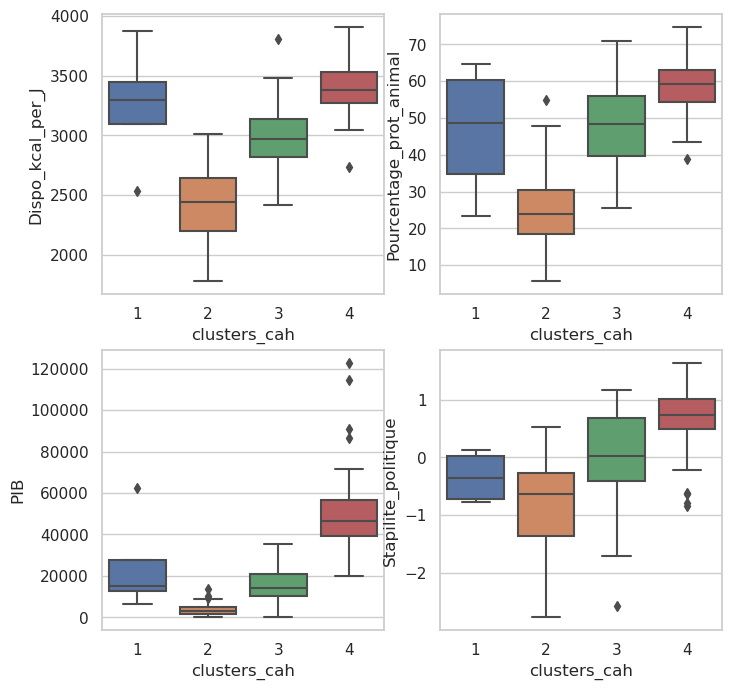

In [39]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=BDD_P9_3, x='clusters_cah', y='Dispo_kcal_per_J')
plt.subplot(222)
sns.boxplot(data=BDD_P9_3, x='clusters_cah', y='Pourcentage_prot_animal')
plt.subplot(223)
sns.boxplot(data=BDD_P9_3, x='clusters_cah', y='PIB')
plt.subplot(224)
sns.boxplot(data=BDD_P9_3, x='clusters_cah', y='Stapilite_politique')

<Axes: xlabel='clusters_cah', ylabel='Production'>

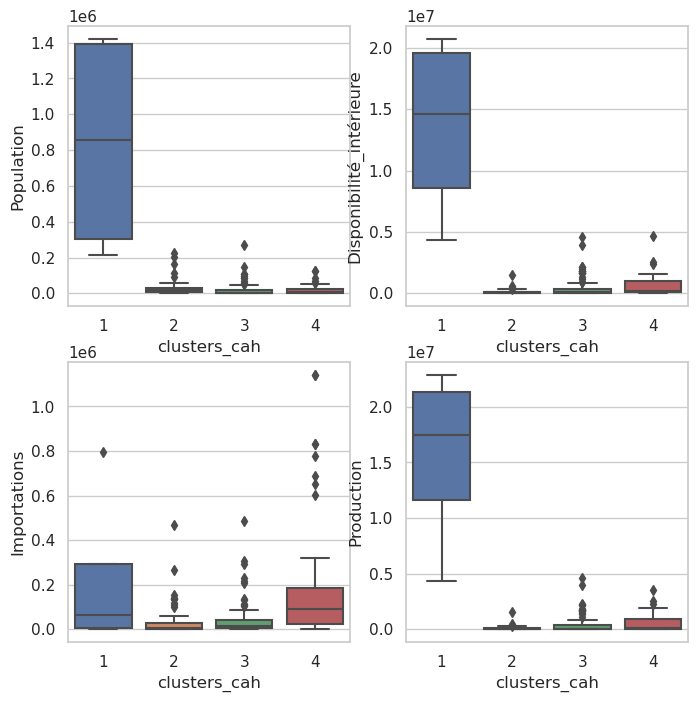

In [40]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=BDD_P9_3, x='clusters_cah', y='Population')
plt.subplot(222)
sns.boxplot(data=BDD_P9_3, x='clusters_cah', y='Disponibilité_intérieure')
plt.subplot(223)
sns.boxplot(data=BDD_P9_3, x='clusters_cah', y='Importations')
plt.subplot(224)
sns.boxplot(data=BDD_P9_3, x='clusters_cah', y='Production')

Conclusion
Deux groupes ce démarquent des autres pour notre objectif d'exportation de poulet :

le groupe 4 : Ce groupe inclus des pays :

  * Dispo_kcal_per_J des plus élevé
  * Pourcentage_prot_animal des plus élevé
  * PIB des plus élevé
  * Stapilite_politique des plus élevé
  * Importations des plus élevé
  * Production faible

le groupe 1:
Ce groupe inclus des pays :

  * Dispo_kcal_per_J élevé
  * Pourcentage_prot_animal élevé
  * PIB élevé
  * Stapilite_politique élevé
  * Population des plus élevé
  * Importations élevé

In [41]:
DFgroupedcah=BDD_P9_3.groupby(['clusters_cah']).mean().reset_index()
DFgroupedcah

,clusters_cah,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production
0,1,46.347500,24937.450000,837769.657500,-0.337500,3249.500000,1.357425e+07,230750.000000,1.553000e+07
1,2,25.244167,3612.041667,29253.257000,-0.845833,2429.716667,1.352000e+05,35716.666667,1.011000e+05
2,3,47.816410,15344.516667,21122.493718,0.032308,2992.653846,4.933590e+05,46871.794872,4.853718e+05
3,4,58.311905,50786.314286,21391.265238,0.635952,3406.642857,6.263810e+05,224595.238095,5.941905e+05


In [42]:
BDD_P9_3[BDD_P9_3['clusters_cah']==4]

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,clusters_cah
Pays,,,,,,,,,
Pays-Bas,62.72,56784.0,17363.26,0.85,3468.0,161000.0,602000.0,1048000.0,4
Allemagne,62.57,53874.3,83148.14,0.57,3635.0,1538000.0,831000.0,1544000.0,4
Arabie saoudite,38.81,44955.0,35827.36,-0.61,3220.0,1412000.0,651000.0,800000.0,4
Australie,66.12,49379.1,25357.17,0.91,3504.0,1240000.0,9000.0,1276000.0,4
Autriche,59.26,55806.4,8879.94,0.92,3814.0,158000.0,113000.0,132000.0,4
Bahreïn,54.19,49769.0,1494.19,-0.63,3482.0,72000.0,63000.0,9000.0,4
Belgique,59.98,51977.2,11510.57,0.47,3849.0,189000.0,322000.0,448000.0,4
Canada,55.95,49171.5,37522.58,1.02,3581.0,1530000.0,188000.0,1506000.0,4
Chine - RAS de Hong-Kong,74.79,59588.5,7496.12,-0.22,3191.0,471000.0,779000.0,24000.0,4


In [43]:
BDD_P9_3[BDD_P9_3['clusters_cah']==1]

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,clusters_cah
Pays,,,,,,,,,
Brésil,58.70,14685.1,211782.88,-0.71,3281.0,9952000.0,5000.0,14094000.0,1
"Chine, continentale",38.65,15977.8,1421864.03,0.00,3304.0,20738000.0,795000.0,20761000.0,1
États-Unis d'Amérique,64.75,62478.3,334319.67,0.13,3876.0,19225000.0,123000.0,22878000.0,1
Inde,23.29,6608.6,1383112.05,-0.77,2537.0,4382000.0,0.0,4387000.0,1


## METHODE K-MEANS
### Recherche du nombre de clusters
#### Methode du Coude

In [44]:
from sklearn.cluster import KMeans

/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/

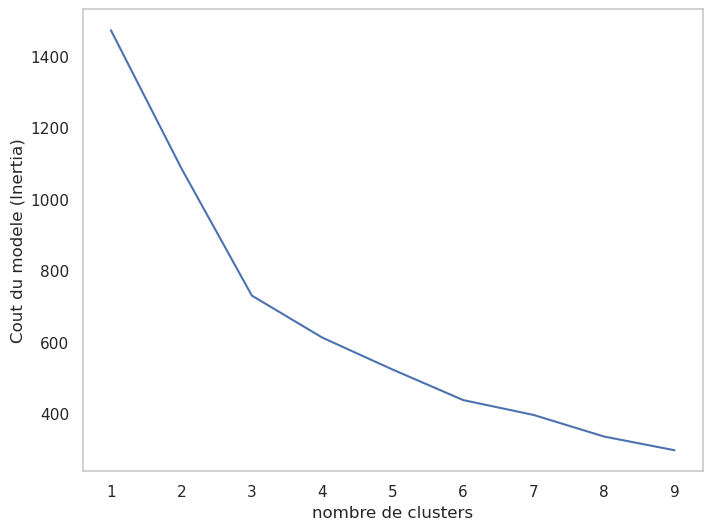

In [45]:
inertia = []
k_range=range(1,10)
for k in k_range:
    model=KMeans(n_clusters=k).fit(X_scaled)
    inertia.append(model.inertia_)
    
fig = plt.figure(figsize=(8,6))
plt.plot(k_range,inertia )
plt.xlabel('nombre de clusters')
plt.ylabel('Cout du modele (Inertia)')
plt.grid()
plt.show()

### Methode de silhouette

/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/

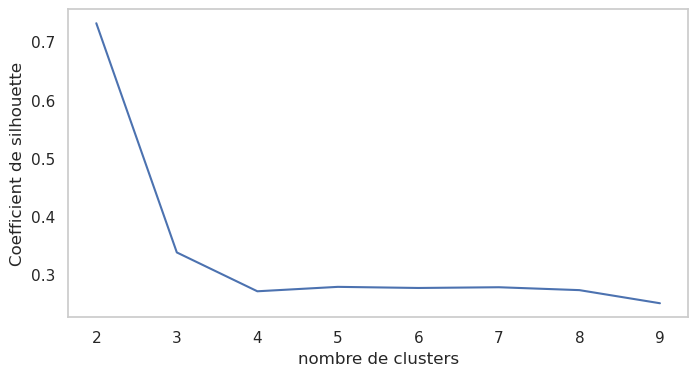

[0.7317891466166483,
 0.33774497826874084,
 0.27096693277411454,
 0.2785693158911342,
 0.27665535504279704,
 0.2779148617196106,
 0.2729420814242345,
 0.25038944981592315]

In [46]:
tab_silhouette =[]
k_range=range(2,10)
for k in k_range:
    model=KMeans(n_clusters=k)
    cluster_labels=model.fit_predict(X_scaled)
    tab_silhouette.append(silhouette_score(X_scaled,cluster_labels))

fig = plt.figure(figsize=(8,4))
plt.plot(k_range,tab_silhouette)
plt.xlabel('nombre de clusters')
plt.ylabel('Coefficient de silhouette')
plt.grid()
plt.show()
tab_silhouette

Observation
Nous avons utilisé 2 méthodes pour determiner le nombre de groupe de cluster :

-Méthode du coude : on remarque que l’inertie stagne à partir de 3 clusters.

-Coefficient de silhouette : celle-ci est un peu différente, elle nous indique que le nombre de cluster idéal serrait de 3.

Pour notre usage, 3 groupes seront certainement insuffisants, nous risquerions de nous retrouver avec une classification “pays riche” /"pays en voie de developpement" et “pays pauvre” vis à vis des données étudiées.
Nous allons donc prendre 4 clusters

### Analyse des clusters

In [47]:
# Clustering par K-means
km = KMeans(n_clusters=4)
km.fit(X_scaled)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

/home/b301njc/.conda/envs/kernel_python_mohamad/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [48]:
km = KMeans(n_clusters=4, n_init=4)  # Spécifiez explicitement n_init
km.fit(X_scaled)


KMeans(n_clusters=4, n_init=4)

In [49]:
BDD_P9_c1 = pd.DataFrame({'cluster': clusters, 'Pays': BDD_P9_final.index})
BDD_P9_c1

,cluster,Pays
0,2,Pays-Bas
1,1,Afghanistan
2,3,Afrique du Sud
3,3,Albanie
4,3,Algérie
5,2,Allemagne
6,1,Angola
7,3,Antigua-et-Barbuda
8,2,Arabie saoudite
9,3,Argentine


In [51]:
# Reset de l'index pour pouvoir merge
BDD_P9_final.reset_index(inplace=True)

In [52]:
#Notre df + les clusters pour pouvoir etudier nos groupes
BDD_P9_c = pd.merge(BDD_P9_final, BDD_P9_c1, on='Pays')
BDD_P9_c.head()

,Pays,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,cluster
0,Pays-Bas,62.72,56784.0,17363.26,0.85,3468.0,161000.0,602000.0,1048000.0,2
1,Afghanistan,17.76,2079.9,37769.50,-2.66,2228.0,69000.0,44000.0,28000.0,1
2,Afrique du Sud,45.17,13852.2,58087.06,-0.27,2827.0,2178000.0,488000.0,1816000.0,3
3,Albanie,53.10,13653.2,2873.88,0.11,3375.0,35000.0,22000.0,13000.0,3
4,Algérie,27.00,11627.3,42705.37,-1.04,3478.0,280000.0,0.0,285000.0,3


In [53]:
BDD_P9_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pays                      184 non-null    object 
 1   Pourcentage_prot_animal   184 non-null    float64
 2   PIB                       184 non-null    float64
 3   Population                184 non-null    float64
 4   Stapilite_politique       184 non-null    float64
 5   Dispo_kcal_per_J          184 non-null    float64
 6   Disponibilité_intérieure  184 non-null    float64
 7   Importations              184 non-null    float64
 8   Production                184 non-null    float64
 9   cluster                   184 non-null    int32  
dtypes: float64(8), int32(1), object(1)
memory usage: 13.8+ KB


In [54]:
BDD_P9_c_grouped = pd.pivot_table(BDD_P9_c, index ='cluster', values= "Pays", aggfunc= len)
BDD_P9_c_grouped

,Pays
cluster,
0,4
1,65
2,36
3,79


In [55]:
BDD_P9_c.set_index('Pays',inplace=True)

## Presentation des 4 clusters

In [56]:
K_cluster_0= BDD_P9_c[BDD_P9_c['cluster']==0]
K_cluster_0

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,cluster
Pays,,,,,,,,,
Brésil,58.70,14685.1,211782.88,-0.71,3281.0,9952000.0,5000.0,14094000.0,0
"Chine, continentale",38.65,15977.8,1421864.03,0.00,3304.0,20738000.0,795000.0,20761000.0,0
États-Unis d'Amérique,64.75,62478.3,334319.67,0.13,3876.0,19225000.0,123000.0,22878000.0,0
Inde,23.29,6608.6,1383112.05,-0.77,2537.0,4382000.0,0.0,4387000.0,0


In [57]:
K_cluster_1= BDD_P9_c[BDD_P9_c['cluster']==1]
K_cluster_1

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,cluster
Pays,,,,,,,,,
Afghanistan,17.76,2079.9,37769.50,-2.66,2228.0,69000.0,44000.0,28000.0,1
Angola,27.20,6602.4,32353.59,-0.36,2427.0,314000.0,265000.0,49000.0,1
Bangladesh,20.26,5467.2,165516.22,-0.93,2513.0,260000.0,0.0,260000.0,1
Bénin,17.89,3156.4,12290.44,-0.41,2687.0,121000.0,117000.0,15000.0,1
Bolivie (État plurinational de),46.27,8528.7,11777.32,-0.73,2419.0,490000.0,2000.0,488000.0,1
Burkina Faso,18.41,2110.1,20951.64,-1.30,2629.0,204000.0,0.0,204000.0,1
Burundi,5.61,729.7,11874.84,-1.62,1780.0,7000.0,0.0,7000.0,1
Cambodge,29.37,4464.3,16207.75,-0.09,2812.0,29000.0,1000.0,28000.0,1
Cameroun,15.28,3756.5,25782.34,-1.56,2833.0,87000.0,2000.0,85000.0,1


In [58]:
K_cluster_2= BDD_P9_c[BDD_P9_c['cluster']==2]
K_cluster_2

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,cluster
Pays,,,,,,,,,
Pays-Bas,62.72,56784.0,17363.26,0.85,3468.0,161000.0,602000.0,1048000.0,2
Allemagne,62.57,53874.3,83148.14,0.57,3635.0,1538000.0,831000.0,1544000.0,2
Arabie saoudite,38.81,44955.0,35827.36,-0.61,3220.0,1412000.0,651000.0,800000.0,2
Australie,66.12,49379.1,25357.17,0.91,3504.0,1240000.0,9000.0,1276000.0,2
Autriche,59.26,55806.4,8879.94,0.92,3814.0,158000.0,113000.0,132000.0,2
Bahreïn,54.19,49769.0,1494.19,-0.63,3482.0,72000.0,63000.0,9000.0,2
Belgique,59.98,51977.2,11510.57,0.47,3849.0,189000.0,322000.0,448000.0,2
Canada,55.95,49171.5,37522.58,1.02,3581.0,1530000.0,188000.0,1506000.0,2
Chine - RAS de Hong-Kong,74.79,59588.5,7496.12,-0.22,3191.0,471000.0,779000.0,24000.0,2


In [59]:
K_cluster_3= BDD_P9_c[BDD_P9_c['cluster']==3]
K_cluster_3

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,cluster
Pays,,,,,,,,,
Afrique du Sud,45.17,13852.2,58087.06,-0.27,2827.0,2178000.0,488000.0,1816000.0,3
Albanie,53.10,13653.2,2873.88,0.11,3375.0,35000.0,22000.0,13000.0,3
Algérie,27.00,11627.3,42705.37,-1.04,3478.0,280000.0,0.0,285000.0,3
Antigua-et-Barbuda,64.57,23035.7,92.12,0.95,2455.0,7000.0,7000.0,0.0,3
Argentine,61.15,22071.7,44745.52,-0.09,3270.0,2021000.0,5000.0,2249000.0,3
Arménie,47.00,14317.6,2820.60,-0.41,3230.0,56000.0,43000.0,12000.0,3
Azerbaïdjan,35.53,14442.0,10232.75,-0.69,3269.0,146000.0,39000.0,112000.0,3
Bahamas,65.18,35161.8,404.56,0.82,2552.0,22000.0,25000.0,6000.0,3
Barbade,56.82,15954.8,280.18,1.05,3137.0,18000.0,2000.0,16000.0,3


### Distribution des variables par groupes à l'aide de boite à moustache

<Axes: xlabel='cluster', ylabel='Stapilite_politique'>

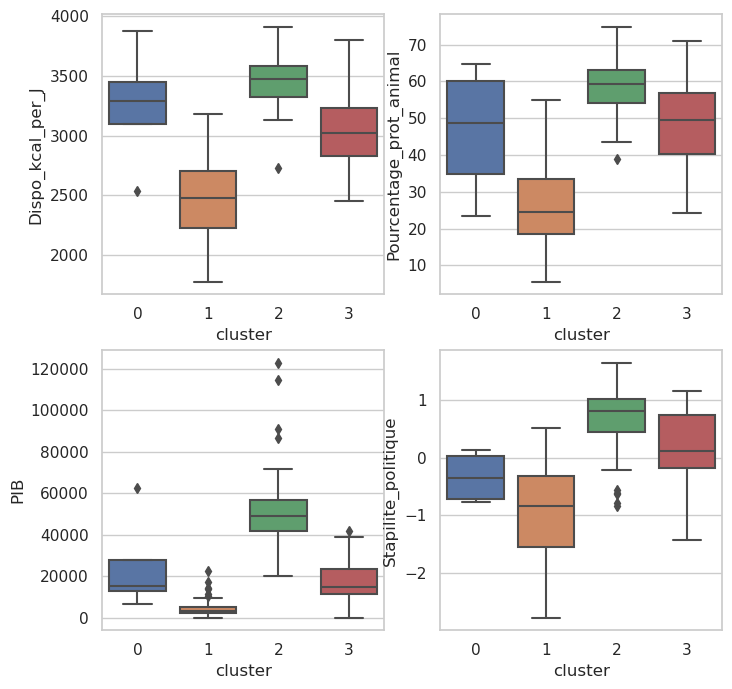

In [60]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=BDD_P9_c, x='cluster', y='Dispo_kcal_per_J')
plt.subplot(222)
sns.boxplot(data=BDD_P9_c, x='cluster', y='Pourcentage_prot_animal')
plt.subplot(223)
sns.boxplot(data=BDD_P9_c, x='cluster', y='PIB')
plt.subplot(224)
sns.boxplot(data=BDD_P9_c, x='cluster', y='Stapilite_politique')

<Axes: xlabel='cluster', ylabel='Production'>

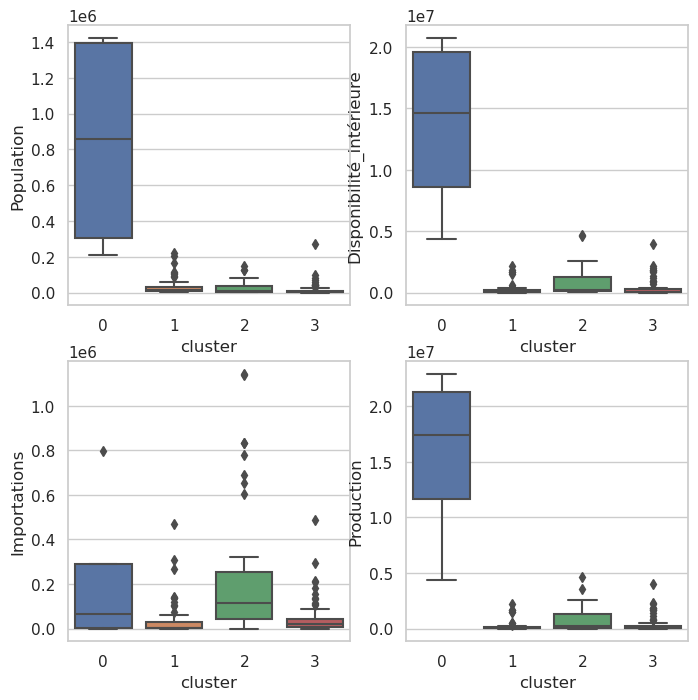

In [61]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=BDD_P9_c, x='cluster', y='Population')
plt.subplot(222)
sns.boxplot(data=BDD_P9_c, x='cluster', y='Disponibilité_intérieure')
plt.subplot(223)
sns.boxplot(data=BDD_P9_c, x='cluster', y='Importations')
plt.subplot(224)
sns.boxplot(data=BDD_P9_c, x='cluster', y='Production')

Conclusion
Deux groupes ce démarquent des autres pour notre objectif d'exportation de poulet :

le groupe **3** : Ce groupe inclus des pays :

  * Dispo_kcal_per_J des plus élevé
  * Pourcentage_prot_animal des plus élevé
  * PIB des plus élevé
  * Stapilite_politique des plus élevé
  * Importations des plus élevé


le groupe **2** :
Ce groupe inclus des pays :

  * Dispo_kcal_per_J élevé
  * Pourcentage_prot_animal élevé
  * PIB élevé
  * Stapilite_politique élevé
  * Population des plus élevé
  * Importations élevé

In [62]:
DFgrouped=BDD_P9_c.groupby(['cluster']).mean().reset_index()
DFgrouped

,cluster,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production
0,0,46.347500,24937.450000,837769.657500,-0.337500,3249.500000,1.357425e+07,230750.000000,1.553000e+07
1,1,26.433692,4452.584615,32263.463231,-0.935538,2462.846154,2.439385e+05,37015.384615,2.087692e+05
2,2,58.286667,53443.488889,27914.841111,0.622778,3440.361111,8.328611e+05,257333.333333,7.943333e+05
3,3,49.074937,16876.410127,15178.780759,0.213544,3017.101266,3.425696e+05,45088.607595,3.381646e+05


In [63]:
K_cluster_3

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,cluster
Pays,,,,,,,,,
Afrique du Sud,45.17,13852.2,58087.06,-0.27,2827.0,2178000.0,488000.0,1816000.0,3
Albanie,53.10,13653.2,2873.88,0.11,3375.0,35000.0,22000.0,13000.0,3
Algérie,27.00,11627.3,42705.37,-1.04,3478.0,280000.0,0.0,285000.0,3
Antigua-et-Barbuda,64.57,23035.7,92.12,0.95,2455.0,7000.0,7000.0,0.0,3
Argentine,61.15,22071.7,44745.52,-0.09,3270.0,2021000.0,5000.0,2249000.0,3
Arménie,47.00,14317.6,2820.60,-0.41,3230.0,56000.0,43000.0,12000.0,3
Azerbaïdjan,35.53,14442.0,10232.75,-0.69,3269.0,146000.0,39000.0,112000.0,3
Bahamas,65.18,35161.8,404.56,0.82,2552.0,22000.0,25000.0,6000.0,3
Barbade,56.82,15954.8,280.18,1.05,3137.0,18000.0,2000.0,16000.0,3


In [64]:
K_cluster_2

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,cluster
Pays,,,,,,,,,
Pays-Bas,62.72,56784.0,17363.26,0.85,3468.0,161000.0,602000.0,1048000.0,2
Allemagne,62.57,53874.3,83148.14,0.57,3635.0,1538000.0,831000.0,1544000.0,2
Arabie saoudite,38.81,44955.0,35827.36,-0.61,3220.0,1412000.0,651000.0,800000.0,2
Australie,66.12,49379.1,25357.17,0.91,3504.0,1240000.0,9000.0,1276000.0,2
Autriche,59.26,55806.4,8879.94,0.92,3814.0,158000.0,113000.0,132000.0,2
Bahreïn,54.19,49769.0,1494.19,-0.63,3482.0,72000.0,63000.0,9000.0,2
Belgique,59.98,51977.2,11510.57,0.47,3849.0,189000.0,322000.0,448000.0,2
Canada,55.95,49171.5,37522.58,1.02,3581.0,1530000.0,188000.0,1506000.0,2
Chine - RAS de Hong-Kong,74.79,59588.5,7496.12,-0.22,3191.0,471000.0,779000.0,24000.0,2


In [65]:
K_cluster_1

,Pourcentage_prot_animal,PIB,Population,Stapilite_politique,Dispo_kcal_per_J,Disponibilité_intérieure,Importations,Production,cluster
Pays,,,,,,,,,
Afghanistan,17.76,2079.9,37769.50,-2.66,2228.0,69000.0,44000.0,28000.0,1
Angola,27.20,6602.4,32353.59,-0.36,2427.0,314000.0,265000.0,49000.0,1
Bangladesh,20.26,5467.2,165516.22,-0.93,2513.0,260000.0,0.0,260000.0,1
Bénin,17.89,3156.4,12290.44,-0.41,2687.0,121000.0,117000.0,15000.0,1
Bolivie (État plurinational de),46.27,8528.7,11777.32,-0.73,2419.0,490000.0,2000.0,488000.0,1
Burkina Faso,18.41,2110.1,20951.64,-1.30,2629.0,204000.0,0.0,204000.0,1
Burundi,5.61,729.7,11874.84,-1.62,1780.0,7000.0,0.0,7000.0,1
Cambodge,29.37,4464.3,16207.75,-0.09,2812.0,29000.0,1000.0,28000.0,1
Cameroun,15.28,3756.5,25782.34,-1.56,2833.0,87000.0,2000.0,85000.0,1


In [66]:
km.cluster_centers_

array([[ 0.70648925,  1.20494468,  0.11408816,  0.33681982,  0.68626937,
         0.47425162,  3.73166983,  0.28707581],
       [-0.86239475, -0.64961682,  0.04777852, -0.71204575, -0.73319016,
        -0.14684305, -0.2646145 , -0.14761123],
       [ 0.74566792,  0.49190204, -0.19928978,  0.66335799,  0.60207681,
        -0.14587107, -0.16751557, -0.1351031 ],
       [ 0.69068044,  0.52581693,  4.08341449, -0.07321168,  1.25468557,
         6.96805928,  1.16035284,  7.23908086]])

In [67]:
table_centro_k = pd.DataFrame(km.cluster_centers_, columns = ["Dispo_kcal_per_J", 
                                                              'Pourcentage_prot_animal', 
                                                              'Population', 
                                                              'Stapilite_politique',
                                                              'PIB',
                                                              'Disponibilité_intérieure',
                                                              "Importations",
                                                              "Production"] )
table_centro_k

,Dispo_kcal_per_J,Pourcentage_prot_animal,Population,Stapilite_politique,PIB,Disponibilité_intérieure,Importations,Production
0,0.706489,1.204945,0.114088,0.336820,0.686269,0.474252,3.731670,0.287076
1,-0.862395,-0.649617,0.047779,-0.712046,-0.733190,-0.146843,-0.264614,-0.147611
2,0.745668,0.491902,-0.199290,0.663358,0.602077,-0.145871,-0.167516,-0.135103
3,0.690680,0.525817,4.083414,-0.073212,1.254686,6.968059,1.160353,7.239081


## Heatmap des centroide du Kmeans

<Axes: >

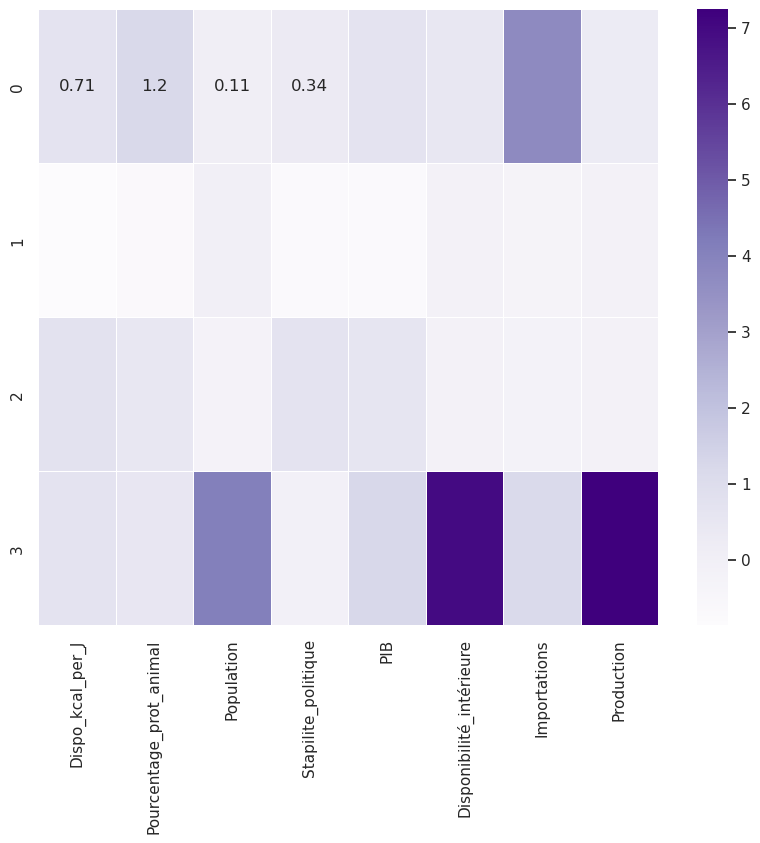

In [68]:
fig, ax = plt.subplots(figsize = (10, 8)) 
cols = table_centro_k.index
idx = table_centro_k.columns

sns.heatmap(table_centro_k, cmap ='Purples', linewidths = 0.50, annot = True)

## Comparaison des deux méthode de clustering

In [69]:
BDD_P9_camparison = pd.merge(BDD_P9_3, BDD_P9_c  , on= "Pays")
pd.crosstab(BDD_P9_camparison['cluster'],BDD_P9_camparison['clusters_cah'])

clusters_cah,1,2,3,4
cluster,,,,
0,4,0,0,0
1,0,58,7,0
2,0,0,1,35
3,0,2,70,7


In [70]:
Cah_clus_1 = BDD_P9_2[BDD_P9_2['clusters_cah']== 1]
Cah_clus_2 = BDD_P9_2[BDD_P9_2['clusters_cah']== 2]
Cah_clus_3 = BDD_P9_2[BDD_P9_2['clusters_cah']== 3]
Cah_clus_4 = BDD_P9_2[BDD_P9_2['clusters_cah']== 4]

In [71]:
Kmeans_clus_0 = BDD_P9_c1[BDD_P9_c1['cluster']== 0]
Kmeans_clus_1 = BDD_P9_c1[BDD_P9_c1['cluster']== 1]
Kmeans_clus_2 = BDD_P9_c1[BDD_P9_c1['cluster']== 2]
Kmeans_clus_3 = BDD_P9_c1[BDD_P9_c1['cluster']== 3]

In [73]:
Group_1=pd.concat([Cah_clus_4, Kmeans_clus_2],axis=1)
Group_1

,clusters_cah,Pays,cluster,Pays
0,4.0,Pays-Bas,2.0,Pays-Bas
5,4.0,Allemagne,2.0,Allemagne
8,4.0,Arabie saoudite,2.0,Arabie saoudite
11,4.0,Australie,2.0,Australie
12,4.0,Autriche,2.0,Autriche
15,4.0,Bahreïn,2.0,Bahreïn
19,4.0,Belgique,2.0,Belgique
33,4.0,Canada,2.0,Canada
35,4.0,Chine - RAS de Hong-Kong,2.0,Chine - RAS de Hong-Kong
36,4.0,Chine - RAS de Macao,2.0,Chine - RAS de Macao


In [75]:
Group_1.shape

(35, 4)

In [81]:
Group_2=pd.concat([Cah_clus_1, Kmeans_clus_0],axis=1)
Group_2

,clusters_cah,Pays,cluster,Pays
26,1,Brésil,0,Brésil
37,1,"Chine, continentale",0,"Chine, continentale"
57,1,États-Unis d'Amérique,0,États-Unis d'Amérique
76,1,Inde,0,Inde


nous retrouvons ici nos 2 groupes qui pourrait nous interesser

### Projection des individus

In [82]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,7))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

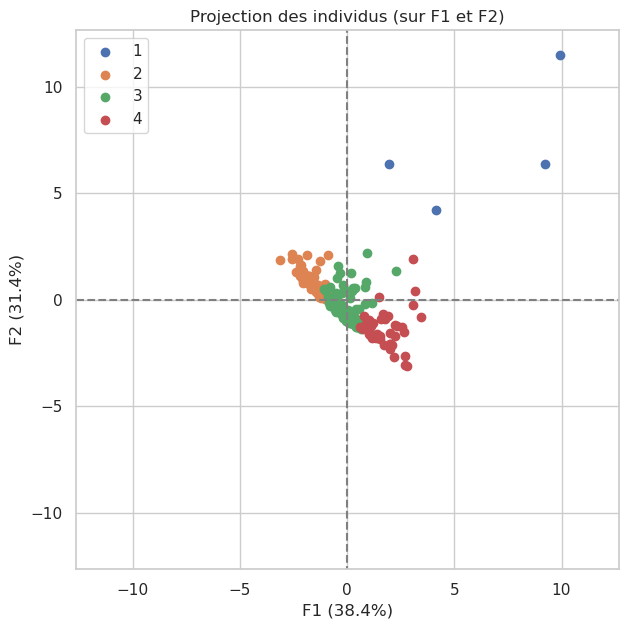

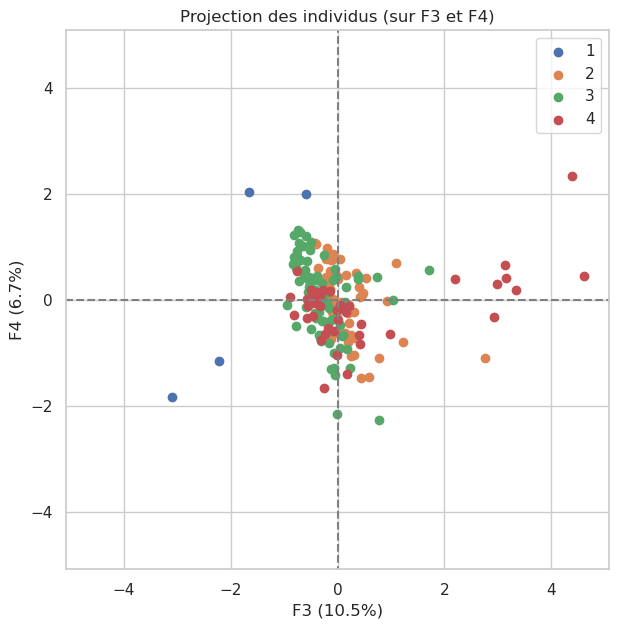

<Figure size 1000x1000 with 0 Axes>

In [87]:
# selection des intitulés des groupes clusters_cah
names = BDD_P9_3["clusters_cah"]  
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], illustrative_var = names, alpha = 1)
figure3 = plt.figure(figsize=(10,10))
plt.show()

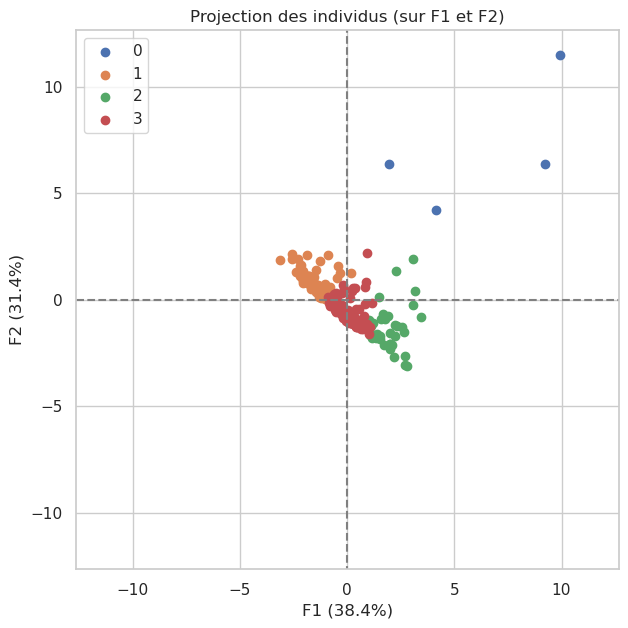

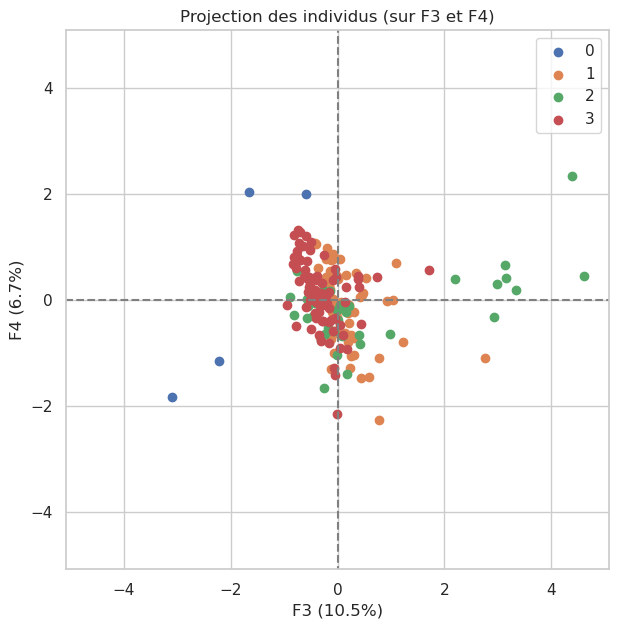

<Figure size 1000x1000 with 0 Axes>

In [83]:
# selection des intitulés des groupes clusters
names = BDD_P9_c["cluster"]  
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], illustrative_var = names, alpha = 1)
figure3 = plt.figure(figsize=(10,10))
plt.show()